In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import  fisk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score

In [61]:
df_income = pd.read_csv('income.csv')
df_income.set_index('year', inplace=True)

df_gini = pd.read_csv('giniIndex.csv')
df_gini.set_index('year', inplace=True)

df_logIncome = df_income.copy()
for year in df_logIncome.index:
    df_logIncome.loc[year] = np.log10(df_logIncome.loc[year])


In [62]:
def closest_index(mylist, number):

    distances = [abs(number - i) for i in mylist]
    return distances.index(min(distances))

def bootstrapping(X, y, size=1):
    regr_list = []
    for n in range(size):
        inds = np.arange(len(X))
        bs_inds = np.random.choice(inds, size=len(inds))

        X_bootstrap = X[bs_inds].reshape(len(inds), 1)
        y_bootstrap = y[bs_inds]

        regr = LinearRegression()
        regr.fit(X_bootstrap, y_bootstrap)
        regr_list.append(regr)

    return regr_list

list_percentiles = [2.5, 50, 97.5]

year_earliest = df_income_modification.index[0]
year_start = df_income_modification.index[-1]
year_end = 2050

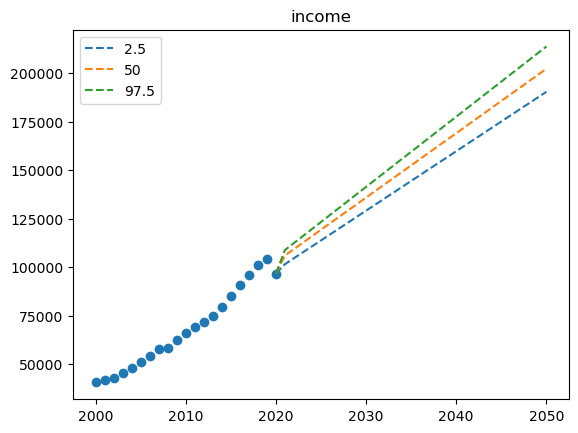

In [63]:
X = np.array(df_income_modification.index)
y = np.array(df_income_modification['total'])

regrList = bootstrapping(X, y,100)
yList = []
for regr in regrList:
    
    x = np.linspace(year_start+1, year_end, year_end-year_start)
    x1 = x.reshape(len(x),1)
    yfit = regr.predict(x1)
    yList.append(yfit[-1])

slope_ci = np.percentile(yList, list_percentile)
regrRequire = {}

for i in list_percentile:
    regr = regrList[closest(yList,slope_ci[list_percentile.index(i)])]
    regrRequire[i] = regr

    x_plot = list(x)
    x_plot.insert(0,year_start)
    y_hat = list(regr.predict(x1))
    y_hat.insert(0, y[-1])
    plt.plot(x_plot, y_hat, linestyle="--", label = i)

plt.title('income')
plt.scatter(X, y)
plt.legend()
plt.show()

2000 (alpha, beta): (0.3343079855449475, 2.994011976047904)
2010 (alpha, beta): (0.5329839217067333, 2.8169014084507045)
2020 (alpha, beta): (0.7863359443919925, 2.770083102493075)
2030 (alpha, beta): (1.0314308636701126, 2.770083102493075)
2040 (alpha, beta): (1.276525782948225, 2.770083102493075)
2050 (alpha, beta): (1.521620702226345, 2.770083102493075)


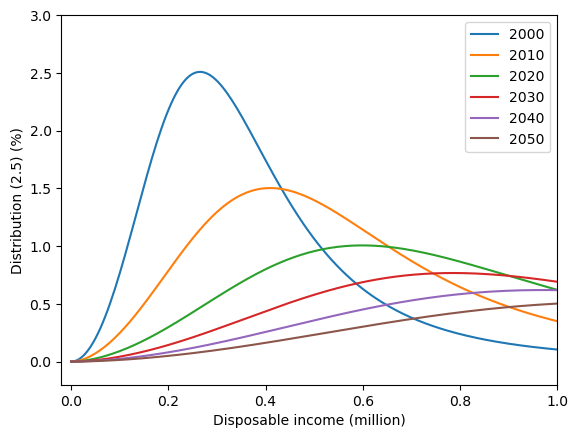

2000 (alpha, beta): (0.3343079855449475, 2.994011976047904)
2010 (alpha, beta): (0.5329839217067333, 2.8169014084507045)
2020 (alpha, beta): (0.8199423743810794, 2.770083102493075)
2030 (alpha, beta): (1.0854434598166265, 2.770083102493075)
2040 (alpha, beta): (1.3509445452521809, 2.770083102493075)
2050 (alpha, beta): (1.6164456306877353, 2.770083102493075)


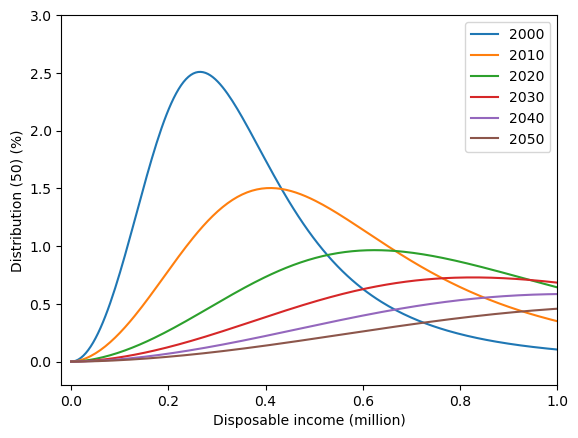

2000 (alpha, beta): (0.3343079855449475, 2.994011976047904)
2010 (alpha, beta): (0.5329839217067333, 2.8169014084507045)
2020 (alpha, beta): (0.8400815832842398, 2.770083102493075)
2030 (alpha, beta): (1.129497897766681, 2.770083102493075)
2040 (alpha, beta): (1.4189142122491147, 2.770083102493075)
2050 (alpha, beta): (1.7083305267315487, 2.770083102493075)


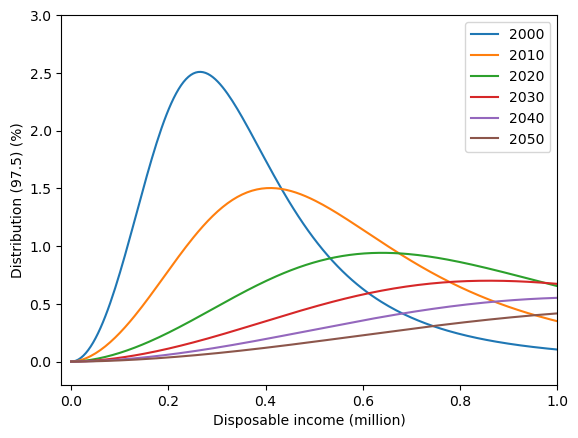

r2: 0.9660411974683729


In [64]:
def LogLogisticDistribution(x, a, b):
    x = np.maximum(x, 1e-10)  # Set a small positive value for zero or negative x
    return fisk.pdf(x, b, 0, a)

def findBetaWithGini(year):
    year_gini_max = max(df_gini['gini'].index)
    if year <= max(df_gini['gini'].index):
        gini = df_gini['gini'][year]
    else:
        gini = df_gini['gini'][year_gini_max]
    return 1.0 / gini

def findAlphaWithMean(beta, mean):
    return mean * np.sin(np.pi / beta) / (np.pi / beta)

incomePast = {}
incomeFuture = {}

for y in df_income_modification.index:
    incomeFuture[y] = df_income_modification['total'][y]

pars_log_future = {}

for m in list_percentile:
    for y in range(df_income_modification.index[0], df_income_modification.index[-1] + 1):
        incomePast[y] = float(regrRequire[m].predict(np.array(y).reshape(1, 1)))

    for y in range(2020, 2051):
        incomeFuture[y] = float(regrRequire[m].predict(np.array(y).reshape(1, 1)))

    pars_log = {}

    for year in incomeFuture.keys():
        b = findBetaWithGini(year)
        a = findAlphaWithMean(b, incomeFuture[year] / 100000)
        pars_log[year] = (a, b)
        pars = pars_log[year]
        if year % 10 == 0:
            x = np.linspace(0, 1, 200)  # Adjust the x range to include negative values
            plt.plot(x, LogLogisticDistribution(x, *pars), '-', label=year)
            print(year, '(alpha, beta):', pars)

    pars_log_future[m] = pars_log

    plt.xlabel('Disposable income (million)')
    plt.ylabel(f'Distribution ({m}) (%)')
    plt.xlim(-0.02, 1)  # Adjust the x-axis limit to include negative values
    plt.ylim(-0.2, 3)
    plt.legend()

    plt.show()

r2 = r2_score(df_income_modification['total'], list(incomePast.values()))
print('r2:', r2)

for m in list_percentile:
    df_pars_log = pd.DataFrame.from_dict(pars_log_future[m], orient='index', columns=['alpha', 'beta'])
    df_pars_log.index.name = 'year'
    df_pars_log.to_csv(f'pars_incomeDistribution_{m}.csv')
